In [1]:
!pip install transformers
!pip install keras tf-models-official pydot graphviz
!pip install emot

     |████████████████████████████████| 2.2 MB 624 kB/s            
     |████████████████████████████████| 61 kB 4.8 MB/s             
     |████████████████████████████████| 99 kB 6.0 MB/s             
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 636 kB 36.0 MB/s            
     |████████████████████████████████| 352 kB 40.6 MB/s            
     |████████████████████████████████| 4.9 MB 38.9 MB/s            
     |████████████████████████████████| 106 kB 38.3 MB/s            
  Installing build dependencies ... - \ | / - \ | / done
  Getting requirements to build wheel ... - \ | / done
  Preparing metadata (pyproject.toml) ... - \ | / done
     |████████████████████████████████| 237 kB 43.3 MB/s            
     |████████████████████████████████| 497.5 MB 19 kB/s              
     |████████████████████████████████| 90 kB 5.3 MB/s             
     |████████████████████████████████| 43 kB 1.3 MB/s             


# Importing libraries

In [2]:
#essentials
import re 
import os
import csv
import glob 
import string  
import random 
import requests 
import numpy as np
import pandas as pd
from datetime import datetime

#preprocessing
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from tqdm.autonotebook import tqdm
import nltk
nltk.download('stopwords')
nltk.download('words')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
import urllib.request
from nltk import pos_tag # For Parts of Speech tagging
from textblob import TextBlob # TextBlob - Python library for processing textual data
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, words # get stopwords from NLTK library & get all words in english language
from nltk.tokenize import word_tokenize # to create word tokens
from nltk.stem import WordNetLemmatizer # to reduce words to orginal form
from emot.emo_unicode import UNICODE_EMOJI # For emojis
from emot.emo_unicode import EMOTICONS_EMO # For EMOTICONS
def extract_emojis(s):
  return ''.join(c for c in s if c in emoji.UNICODE_EMOJI)

#ploting
import seaborn as sns
import matplotlib.pyplot as plt

#model
from sklearn.model_selection import StratifiedKFold

#evaluation
from sklearn.metrics import precision_score, recall_score, f1_score

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  app.launch_new_instance()


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /usr/share/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
from transformers import BertTokenizer, BertForMaskedLM

# loading data

In [4]:
train_df = pd.read_csv('../input/raw-emotions-dataset/train.csv', encoding= 'unicode_escape')
test_df= pd.read_csv('../input/raw-emotions-dataset/test.csv', encoding= 'unicode_escape')
train_df.head()

,text,label
0,that Rutgers game was an abomination. An affro...,anger
1,I get mad over something so minuscule I try to...,anger
2,I get mad over something so minuscule I try to...,anger
3,eyes have been dilated. I hate the world right...,anger
4,One chosen by the CLP members! MP seats are no...,anger


In [5]:
test_df.head()

,text,label
0,#afraid of the #quiet ones they are the ones w...,fear
1,he's a horrible person and now i gag when i se...,fear
2,pedicure is supposed to be nice but honestly I...,fear
3,you need to band together not apart #nevertrum...,fear
4,you need to band together not apart #nevertrum...,fear


In [6]:
print("Training Set Shape :", train_df.shape)
print("Test Set Shape :", test_df.shape)

Training Set Shape : (1870, 2)
Test Set Shape : (1578, 2)


In [7]:
train_df.describe()

,text,label
count,1870,1790
unique,1850,4
top,always unhappy and easily offended.,fear
freq,2,569


In [8]:
test_df.text=test_df.text.astype(str)

In [9]:
test_df.dtypes

text     object
label    object
dtype: object

# 1 Data preprocessing
In this stage, we will;

Creating Meta Features :
Word Count
Unique word count
Mean word length
Length of the text
URL count
Hashtag count
Mention (@)count
stop word count
Punctuation count

In [10]:
# function to obtain adjectives from text
def getAdjectives(text):
    text = word_tokenize(text)  # convert string to tokens
    text = [word for (word, tag) in pos_tag(text)
             if tag == "JJ"]  # pos_tag module in NLTK library
    return " ".join(text)  # join words with a space in between them
def preprocessTextSentiments(text):

    text_tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer() # instatiate an object WordNetLemmatizer Class
    lemma_words = [lemmatizer.lemmatize(w) for w in text_tokens]
    return " ".join(lemma_words)

In [11]:
def clean_df(df):
    #word count
    df['word_count'] = df['text'].apply( lambda x: len(str(x).split()))
    #Unique word count
    df['unique_wordcount'] = df['text'].apply(lambda x: len(set(str(x).split())))

    #Mean word length
    df['mean_word_length'] = df['text'].apply(lambda x: round(np.mean([len(w) for w in str(x).split()]),2))

    #length of the text
    df['text_length'] = df['text'].apply(lambda x: len(x))

    #hashtag count
    df['hashtags'] = df['text'].apply( lambda x: len(re.findall('#.*',x)))

    #mention (@)
    df['mention_count'] = df['text'].apply( lambda x: len(re.findall('@.*',x)))

    # stopword count
    df['stopwords'] = df['text'].apply( lambda x: len([w for w in x.lower().split() if w in STOPWORDS]))

    #punctuation count
    df['punctuation_count'] = df['text'].apply( lambda x: len( re.findall('[%s]' %string.punctuation,x)))

    # Apply getAdjectives function to the new 'Processed Text' column to generate a new column called 'Text_Adjectives'
    df['text_Adjectives'] = df['text'].apply(getAdjectives)
    
    return df


In [12]:
train_df=clean_df(train_df)
test_df=clean_df(test_df)

In [13]:
train_df.head()

,text,label,word_count,unique_wordcount,mean_word_length,text_length,hashtags,mention_count,stopwords,punctuation_count,text_Adjectives
0,that Rutgers game was an abomination. An affro...,anger,19,19,4.16,97,0,0,9,3,
1,I get mad over something so minuscule I try to...,anger,24,21,4.17,123,0,0,13,0,mad minuscule federal
2,I get mad over something so minuscule I try to...,anger,25,22,4.24,130,1,0,13,1,mad minuscule federal
3,eyes have been dilated. I hate the world right...,anger,22,19,4.00,109,0,0,10,3,thousand
4,One chosen by the CLP members! MP seats are no...,anger,22,21,4.27,115,1,0,10,4,


In [14]:
#function removes '@',  http links, punctuations, emojis, and stop words from data
def preprocess(text): 
    
    '''
Apply preprocess function to the 'text' column to generate a new column called 'Processed text'.
This function will;
1. remove urls, 
2. remove @ and #.
3. Remove punctuations 
4. Remove emojis
5. remove stop words
'''
    # Remove user @ references and '#' from text
    text = re.sub(r'\@\w+|\#|\d+', '', text)

    # Remove punctuations
    text = re.sub('[%s]' % re.escape(string.punctuation),'',text)
    
    # Typos, slang and informal abbreviations
    text = re.sub(r"w/e", "whatever", text)
    text = re.sub(r"w/", "with", text)
    text = re.sub(r"USAgov", "USA government", text)
    text = re.sub(r"recentlu", "recently", text)
    text = re.sub(r"Ph0tos", "Photos", text)
    text = re.sub(r"amirite", "am I right", text)
    text = re.sub(r"exp0sed", "exposed", text)
    text = re.sub(r"<3", "love", text)
    text = re.sub(r"amageddon", "armageddon", text)
    text = re.sub(r"Trfc", "Traffic", text)
    text = re.sub(r"8/5/2015", "2015-08-05", text)
    text = re.sub(r"WindStorm", "Wind Storm", text)
    text = re.sub(r"8/6/2015", "2015-08-06", text)
    text = re.sub(r"10:38PM", "10:38 PM", text)
    text = re.sub(r"10:30pm", "10:30 PM", text)
    text = re.sub(r"16yr", "16 year", text)
    text = re.sub(r"lmao", "laughing my ass off", text)   
    text = re.sub(r"TRAUMATISED", "traumatized", text)

    # Character entity references
    text = re.sub(r"&gt;", ">", text)
    text = re.sub(r"&lt;", "<", text)
    text = re.sub(r"&amp;", "&", text)

    # Contractions
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"there's", "there is", text)
    text = re.sub(r"We're", "We are", text)
    text = re.sub(r"That's", "That is", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"they're", "they are", text)
    text = re.sub(r"Can't", "Cannot", text)
    text = re.sub(r"wasn't", "was not", text)
    text = re.sub(r"don\x89Ûªt", "do not", text)
    text = re.sub(r"aren't", "are not", text)
    text = re.sub(r"isn't", "is not", text)
    text = re.sub(r"What's", "What is", text)
    text = re.sub(r"haven't", "have not", text)
    text = re.sub(r"hasn't", "has not", text)
    text = re.sub(r"There's", "There is", text)
    text = re.sub(r"He's", "He is", text)
    text = re.sub(r"It's", "It is", text)
    text = re.sub(r"You're", "You are", text)
    text = re.sub(r"I'M", "I am", text)
    text = re.sub(r"shouldn't", "should not", text)
    text = re.sub(r"wouldn't", "would not", text)
    text = re.sub(r"i'm", "I am", text)
    text = re.sub(r"I\x89Ûªm", "I am", text)
    text = re.sub(r"I'm", "I am", text)
    text = re.sub(r"Isn't", "is not", text)
    text = re.sub(r"Here's", "Here is", text)
    text = re.sub(r"you've", "you have", text)
    text = re.sub(r"you\x89Ûªve", "you have", text)
    text = re.sub(r"we're", "we are", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"we've", "we have", text)
    text = re.sub(r"it\x89Ûªs", "it is", text)
    text = re.sub(r"doesn\x89Ûªt", "does not", text)
    text = re.sub(r"It\x89Ûªs", "It is", text)
    text = re.sub(r"Here\x89Ûªs", "Here is", text)
    text = re.sub(r"who's", "who is", text)
    text = re.sub(r"I\x89Ûªve", "I have", text)
    text = re.sub(r"y'all", "you all", text)
    text = re.sub(r"can\x89Ûªt", "cannot", text)
    text = re.sub(r"would've", "would have", text)
    text = re.sub(r"it'll", "it will", text)
    text = re.sub(r"we'll", "we will", text)
    text = re.sub(r"wouldn\x89Ûªt", "would not", text)
    text = re.sub(r"We've", "We have", text)
    text = re.sub(r"he'll", "he will", text)
    text = re.sub(r"Y'all", "You all", text)
    text = re.sub(r"Weren't", "Were not", text)
    text = re.sub(r"Didn't", "Did not", text)
    text = re.sub(r"they'll", "they will", text)
    text = re.sub(r"they'd", "they would", text)
    text = re.sub(r"DON'T", "DO NOT", text)
    text = re.sub(r"That\x89Ûªs", "That is", text)
    text = re.sub(r"they've", "they have", text)
    text = re.sub(r"i'd", "I would", text)
    text = re.sub(r"should've", "should have", text)
    text = re.sub(r"You\x89Ûªre", "You are", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"Don\x89Ûªt", "Do not", text)
    text = re.sub(r"we'd", "we would", text)
    text = re.sub(r"i'll", "I will", text)
    text = re.sub(r"weren't", "were not", text)
    text = re.sub(r"They're", "They are", text)
    text = re.sub(r"Can\x89Ûªt", "Cannot", text)
    text = re.sub(r"you\x89Ûªll", "you will", text)
    text = re.sub(r"I\x89Ûªd", "I would", text)
    text = re.sub(r"let's", "let us", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"you're", "you are", text)
    text = re.sub(r"i've", "I have", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"i'll", "I will", text)
    text = re.sub(r"doesn't", "does not", text)
    text = re.sub(r"i'd", "I would", text)
    text = re.sub(r"didn't", "did not", text)
    text = re.sub(r"ain't", "am not", text)
    text = re.sub(r"you'll", "you will", text)
    text = re.sub(r"I've", "I have", text)
    text = re.sub(r"Don't", "do not", text)
    text = re.sub(r"I'll", "I will", text)
    text = re.sub(r"I'd", "I would", text)
    text = re.sub(r"Let's", "Let us", text)
    text = re.sub(r"you'd", "You would", text)
    text = re.sub(r"It's", "It is", text)
    text = re.sub(r"Ain't", "am not", text)
    text = re.sub(r"Haven't", "Have not", text)
    text = re.sub(r"Could've", "Could have", text)
    text = re.sub(r"youve", "you have", text)  
    text = re.sub(r"donå«t", "do not", text)  

    # Special characters
    text = re.sub(r"\x89Û_", "", text)
    text = re.sub(r"\x89ÛÒ", "", text)
    text = re.sub(r"\x89ÛÓ", "", text)
    text = re.sub(r"\x89ÛÏWhen", "When", text)
    text = re.sub(r"\x89ÛÏ", "", text)
    text = re.sub(r"China\x89Ûªs", "China's", text)
    text = re.sub(r"let\x89Ûªs", "let's", text)
    text = re.sub(r"\x89Û÷", "", text)
    text = re.sub(r"\x89Ûª", "", text)
    text = re.sub(r"\x89Û\x9d", "", text)
    text = re.sub(r"å_", "", text)
    text = re.sub(r"\x89Û¢", "", text)
    text = re.sub(r"\x89Û¢åÊ", "", text)
    text = re.sub(r"fromåÊwounds", "from wounds", text)
    text = re.sub(r"åÊ", "", text)
    text = re.sub(r"åÈ", "", text)
    text = re.sub(r"JapÌ_n", "Japan", text)    
    text = re.sub(r"Ì©", "e", text)
    text = re.sub(r"å¨", "", text)
    text = re.sub(r"SuruÌ¤", "Suruc", text)
    text = re.sub(r"åÇ", "", text)
    text = re.sub(r"å£3million", "3 million", text)
    text = re.sub(r"åÀ", "", text) 

    #reduce text to lowercase 
    text = text.lower()  

    #convert string to tokens
    PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
    tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
    tokens = tokenizer.tokenize(text) 

    # Remove stopwords
    filtered_words = [w for w in tokens if w not in stop_words]
    filtered_words = [w for w in filtered_words if w not in emojis]
    filtered_words = [w for w in filtered_words if w in word_list]
  
    return text
    # Remove punctuations
    unpunctuated_words = [char for char in filtered_words if char not in string.punctuation]
    unpunctuated_words = ' '.join(unpunctuated_words)

    return "".join(unpunctuated_words)  # join words with a space in between them

In [15]:
# Defining my NLTK stop words
stop_words = list(stopwords.words('english'))
alphabets = list(string.ascii_lowercase)
stop_words = stop_words + alphabets
word_list = words.words()  # all words in English language
emojis = list(UNICODE_EMOJI.keys())  # full list of emojis

In [16]:
train_df['Processed_Text'] = train_df['text'].apply(preprocess)
test_df['Processed_Text'] = test_df['text'].apply(preprocess)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [17]:
#printing results for better analysis
print(train_df['text'][19])
print(train_df['Processed_Text'][19])

scrubbed hands 5 times before trying to put them in.
scrubbed hands  times before trying to put them in


In [18]:
train_df[['text','Processed_Text']].head()


,text,Processed_Text
0,that Rutgers game was an abomination. An affro...,that rutgers game was an abomination an affron...
1,I get mad over something so minuscule I try to...,i get mad over something so minuscule i try to...
2,I get mad over something so minuscule I try to...,i get mad over something so minuscule i try to...
3,eyes have been dilated. I hate the world right...,eyes have been dilated i hate the world right ...
4,One chosen by the CLP members! MP seats are no...,one chosen by the clp members mp seats are not...


In [19]:
train_df.to_csv('preprocessedEmotionTrain.csv')
test_df.to_csv('preprocessedEmotionTest.csv')


In [20]:
train_df.head()

,text,label,word_count,unique_wordcount,mean_word_length,text_length,hashtags,mention_count,stopwords,punctuation_count,text_Adjectives,Processed_Text
0,that Rutgers game was an abomination. An affro...,anger,19,19,4.16,97,0,0,9,3,,that rutgers game was an abomination an affron...
1,I get mad over something so minuscule I try to...,anger,24,21,4.17,123,0,0,13,0,mad minuscule federal,i get mad over something so minuscule i try to...
2,I get mad over something so minuscule I try to...,anger,25,22,4.24,130,1,0,13,1,mad minuscule federal,i get mad over something so minuscule i try to...
3,eyes have been dilated. I hate the world right...,anger,22,19,4.00,109,0,0,10,3,thousand,eyes have been dilated i hate the world right ...
4,One chosen by the CLP members! MP seats are no...,anger,22,21,4.27,115,1,0,10,4,,one chosen by the clp members mp seats are not...


In [21]:
train_df=train_df.dropna()
test_df=test_df.dropna()


In [22]:
classes = train_df.label.unique()
classes

array(['anger', 'sadness', 'fear', 'joy'], dtype=object)

In [23]:
happy_df = train_df.loc[train_df['label']=='joy']['Processed_Text'] #joy tweets 
happy_df = happy_df.apply(lambda x: ' '.join([w for w in x.split() if w not in STOPWORDS])) # removing stopwords
happy_df.head()

469    got back seeing burslem amazing face still hur...
470    dear evening absolute hilarity dont think laug...
471                       waiting week game cheer friday
472    thank much gloria youre sweet thoughtful made ...
473    feel blessed work family nanny nothing love am...
Name: Processed_Text, dtype: object

In [24]:
angry_df = train_df.loc[train_df['label']=='anger']['Processed_Text'] #anger tweets 
angry_df = angry_df.apply(lambda x: ' '.join([w for w in x.split() if w not in STOPWORDS])) #removing stopwords
angry_df.head()

0    rutgers game abomination affront god man must ...
1    mad something minuscule try ruin somebodies li...
2    mad something minuscule try ruin somebodies li...
3    eyes dilated hate world right now rage thousan...
4    one chosen clp members mp seats people dole ma...
Name: Processed_Text, dtype: object

In [25]:
sad_df = train_df.loc[train_df['label']=="sadness"]['Processed_Text'] #optimism tweets 
sad_df = sad_df.apply(lambda x: ' '.join([w for w in x.split() if w not in STOPWORDS])) #removing stopwords
sad_df.head()

37                                     sucks depression
38                          worthless always depression
39                                     worthless always
40    fibromyalgia really bad lately good mental sta...
41      think ima lay bed day sulk life hitting hard rn
Name: Processed_Text, dtype: object

In [26]:
neutral_df = train_df.loc[train_df['label']== 'fear']['Processed_Text'] #optimism tweets 
neutral_df = neutral_df.apply(lambda x: ' '.join([w for w in x.split() if w not in STOPWORDS])) #removing stopwords
neutral_df.head()

426      know going one nights takes act god fall asleep
427    w rock jack black kevin hartare kidding wtf th...
428    w rock jack black kevin hartare kidding wtf th...
429    concerns amp anxiety dont matter return favor ...
430     goes butterflies stomach nervous anxietyproblems
Name: Processed_Text, dtype: object

<AxesSubplot:>

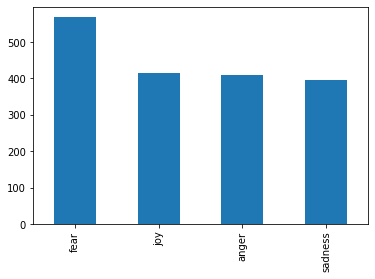

In [27]:
#Distribution of classes
train_df['label'].value_counts().plot(kind = 'bar')

Text(0.5, 1.0, 'Joy text')

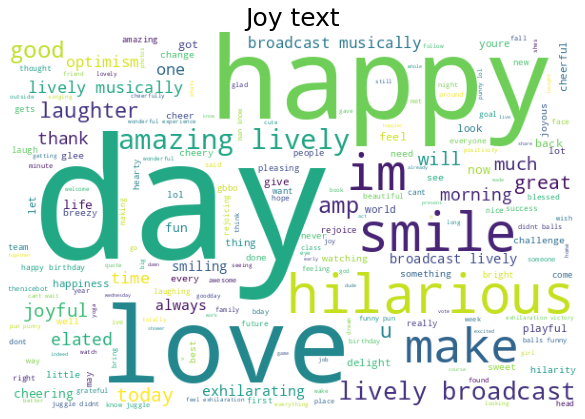

In [28]:
plt.figure(figsize=(20,7))
wordcloud1 = WordCloud(background_color ='white',width=600, height= 400).generate(' '.join(happy_df))
plt.imshow(wordcloud1)
plt.axis('off')
plt.title('Joy text',fontsize=25)

Text(0.5, 1.0, 'Sad text')

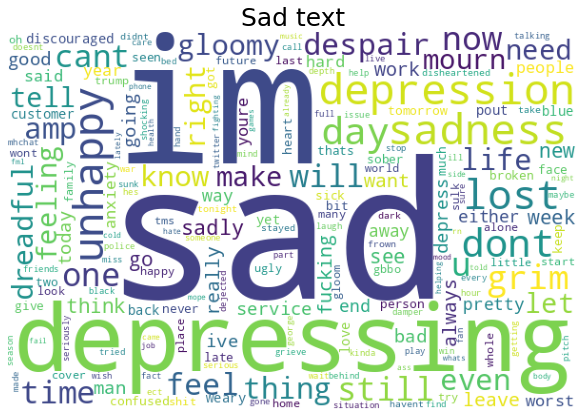

In [29]:
plt.figure(figsize=(20,7))
wordcloud2 = WordCloud(background_color ='white',width =600, height =400).generate(' '.join(sad_df))
plt.imshow(wordcloud2)
plt.axis('off')
plt.title('Sad text',fontsize=25)

Text(0.5, 1.0, 'Angry text')

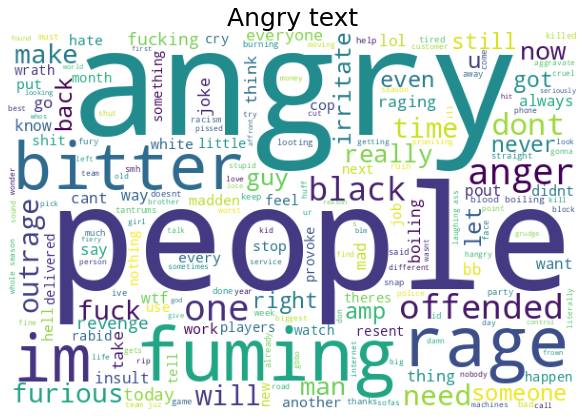

In [30]:
plt.figure(figsize=(20,7))
wordcloud2 = WordCloud(background_color ='white',width =600, height =400).generate(' '.join(angry_df))
plt.imshow(wordcloud2)
plt.axis('off')
plt.title('Angry text',fontsize=25)

Text(0.5, 1.0, 'fear text')

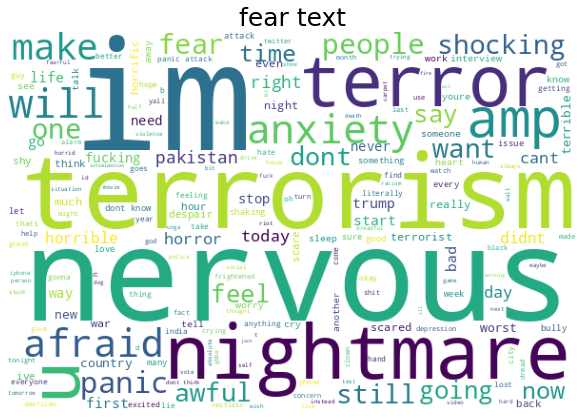

In [31]:
plt.figure(figsize=(20,7))
wordcloud2 = WordCloud(background_color ='white',width =600, height =400).generate(' '.join(neutral_df))
plt.imshow(wordcloud2)
plt.axis('off')
plt.title('fear text',fontsize=25)

# Modeling

Train- Validate split


In [32]:
data = train_df[['label','Processed_Text' ]]
from sklearn.model_selection import train_test_split

X = data.Processed_Text.values
y = data.label.values

X_train, X_val, y_train, y_val =\
    train_test_split(X, y, test_size=0.2, random_state=2020)


In [33]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [34]:
def get_auc_CV(model):
    """
    Return the average AUC score from cross-validation.
    """
    # Set KFold to shuffle data before the split
    kf = StratifiedKFold(5, shuffle=True, random_state=1)

    # Get AUC scores
    auc = cross_val_score(
        model, X_train_tfidf, y_train, scoring="roc_auc", cv=kf)

    return auc.mean()

# Naive Bayes Classifier
MultinominalNB


In [35]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

Evaluation on Validation Set

In [36]:
labels = ['optimism ',' anger','joy','sadness ']

In [37]:
%%time
from sklearn.metrics import classification_report
y_pred = nb.predict(X_val)

print('accuracy %s' % accuracy_score(y_pred, y_val))
print(classification_report(y_val, y_pred,target_names=labels))

accuracy 0.6731843575418994
              precision    recall  f1-score   support

   optimism        0.91      0.58      0.71        86
       anger       0.51      0.96      0.67       112
         joy       0.95      0.69      0.80        85
    sadness        0.77      0.32      0.45        75

    accuracy                           0.67       358
   macro avg       0.79      0.64      0.66       358
weighted avg       0.77      0.67      0.67       358

CPU times: user 22.6 ms, sys: 19 µs, total: 22.6 ms
Wall time: 21.7 ms


# SVM classifier


In [38]:
from sklearn import svm


nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', svm.SVC(kernel='poly', degree=4)),
              ])
nb.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', SVC(degree=4, kernel='poly'))])

In [39]:
%%time
from sklearn.metrics import classification_report
y_pred = nb.predict(X_val)

print('accuracy %s' % accuracy_score(y_pred, y_val))
print(classification_report(y_val, y_pred,target_names=labels))

accuracy 0.4664804469273743
              precision    recall  f1-score   support

   optimism        0.92      0.27      0.41        86
       anger       0.37      0.99      0.54       112
         joy       1.00      0.33      0.50        85
    sadness        0.83      0.07      0.12        75

    accuracy                           0.47       358
   macro avg       0.78      0.41      0.39       358
weighted avg       0.75      0.47      0.41       358

CPU times: user 81.9 ms, sys: 0 ns, total: 81.9 ms
Wall time: 81.7 ms


# Enseble Extra tree

In [40]:
from sklearn.ensemble import ExtraTreesClassifier 
from sklearn.datasets import make_classification

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', ExtraTreesClassifier(n_estimators=100, random_state=0)),
              ])
nb.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', ExtraTreesClassifier(random_state=0))])

In [41]:
%%time
y_pred = nb.predict(X_val)

print('accuracy %s' % accuracy_score(y_pred, y_val))
print(classification_report(y_val, y_pred,target_names=labels))

accuracy 0.835195530726257
              precision    recall  f1-score   support

   optimism        0.82      0.87      0.84        86
       anger       0.80      0.87      0.83       112
         joy       0.91      0.88      0.90        85
    sadness        0.84      0.69      0.76        75

    accuracy                           0.84       358
   macro avg       0.84      0.83      0.83       358
weighted avg       0.84      0.84      0.83       358

CPU times: user 69 ms, sys: 3.96 ms, total: 73 ms
Wall time: 72.7 ms


# Train on whole training set:

In [42]:
nb.fit(X, y)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', ExtraTreesClassifier(random_state=0))])

In [43]:
%%time

y_pred1 = nb.predict(X)

print('accuracy %s' % accuracy_score(y_pred1, y))
print(classification_report(y, y_pred1,target_names=labels))

accuracy 0.9916201117318436
              precision    recall  f1-score   support

   optimism        0.98      1.00      0.99       409
       anger       0.99      1.00      0.99       569
         joy       1.00      1.00      1.00       416
    sadness        1.00      0.96      0.98       396

    accuracy                           0.99      1790
   macro avg       0.99      0.99      0.99      1790
weighted avg       0.99      0.99      0.99      1790

CPU times: user 207 ms, sys: 0 ns, total: 207 ms
Wall time: 205 ms


# Test set predictions:

In [44]:
X_Test = test_df.Processed_Text.values
y_Test = test_df.label.values

In [45]:
%%time

y_pred2 = nb.predict(X_Test)

print('accuracy %s' % accuracy_score(y_pred2, y_Test))
print(classification_report(y_Test, y_pred2,target_names=labels))

accuracy 0.8093023255813954
              precision    recall  f1-score   support

   optimism        0.81      0.75      0.78       350
       anger       0.77      0.82      0.80       472
         joy       0.90      0.88      0.89       356
    sadness        0.77      0.78      0.77       327

    accuracy                           0.81      1505
   macro avg       0.81      0.81      0.81      1505
weighted avg       0.81      0.81      0.81      1505

CPU times: user 181 ms, sys: 3.91 ms, total: 185 ms
Wall time: 183 ms
